# Table of Contents
 <p>

In [4]:
# important stuff:
import os
import pandas as pd
import numpy as np
import scipy
import statsmodels.tools.numdiff as smnd


# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import epistasis as epi
import gvars

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

from scipy.stats import gaussian_kde

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [13]:
# simulate data:
xdata = np.linspace(-10, 10, 40)
ydata = np.linspace(5, -5, 40) + np.random.normal(0, 0.5, 40)

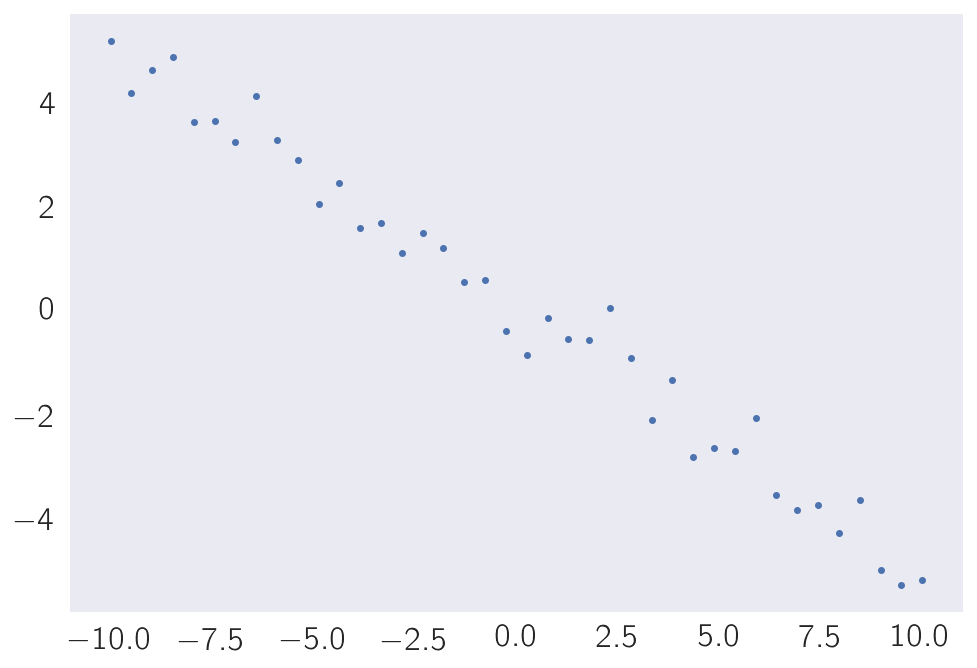

In [14]:
plt.plot(xdata, ydata, '.')

In [23]:
import emcee

# Define our posterior using Python functions
# for clarity, I've separated-out the prior and likelihood
# but this is not necessary. Note that emcee requires log-posterior

def log_prior(theta):
    beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    beta, sigma = theta
    y_model = beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

# Here we'll set up the computation. emcee combines multiple "walkers",
# each of which is its own MCMC chain. The number of trace results will
# be nwalkers * nsteps

ndim = 2  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# set theta near the maximum likelihood, with 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# Here's the function call where all the work happens:
# we'll time it using IPython's %time magic

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[xdata, ydata])
%time sampler.run_mcmc(starting_guesses, nsteps)
print("done")

CPU times: user 2.56 s, sys: 10.6 ms, total: 2.57 s
Wall time: 2.58 s
done


In [24]:
def compute_sigma_level(trace1, nbins=20):
    """From a set of traces, bin by number of standard deviations"""
    L, xbins = np.histogram2d(trace1, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    # obtain the indices to sort and unsort the flattened array
    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)

    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]
    
    xbins = 0.5 * (xbins[1:] + xbins[:-1])

    return xbins, L_cumsum[i_unsort].reshape(shape)


def plot_MCMC_trace(ax, xdata, ydata, trace, scatter=False, **kwargs):
    """Plot traces and contours"""
#     xbins, ybins, sigma = compute_sigma_level(trace[0])
    sns.distplot(trace[0], ax=ax)
#     ax.contour(xbins, ybins, sigma.T, levels=[0.683, 0.955], **kwargs)
#     if scatter:
#         ax.plot(trace[0], trace[1], ',k', alpha=0.1)
#     ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\beta$')
    
    
def plot_MCMC_model(ax, xdata, ydata, trace):
    """Plot the linear model and 2sigma contours"""
    ax.plot(xdata, ydata, 'ok')

    beta = trace[0]
    xfit = np.linspace(-20, 20, 10)
    yfit = beta[:, None]* xfit
    mu = yfit.mean(0)
    sig = 2 * yfit.std(0)

    ax.plot(xfit, mu, '-k')
    ax.fill_between(xfit, mu - sig, mu + sig, color='lightgray')

    ax.set_xlabel('x')
    ax.set_ylabel('y')


def plot_MCMC_results(xdata, ydata, trace, colors='k'):
    """Plot both the trace and the model together"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plot_MCMC_trace(ax[0], xdata, ydata, trace, True, colors=colors)
    plot_MCMC_model(ax[1], xdata, ydata, trace)


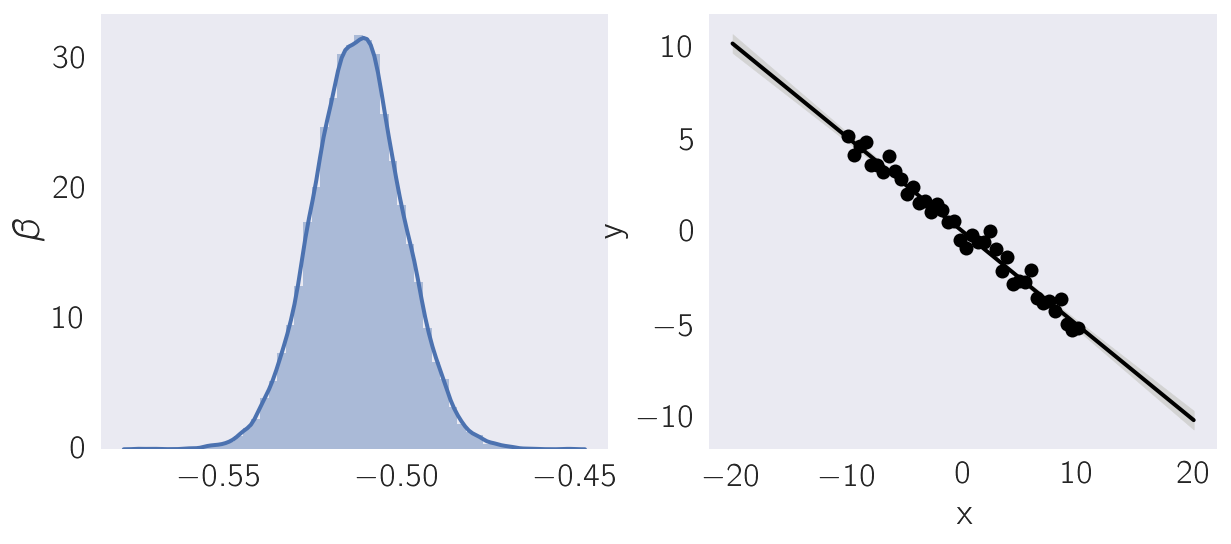

In [25]:
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# we'll throw-out the burn-in points and reshape:
emcee_trace = sampler.chain[:, nburn:, :].reshape(-1, ndim).T
plot_MCMC_results(xdata, ydata, emcee_trace)


In [18]:
emcee_trace

array([[-0.52835159, -0.52741169, -0.52741169, ..., -0.47905528,
        -0.47905528, -0.47905528],
       [ 0.44804274,  0.44717237,  0.44717237, ...,  0.48452151,
         0.48452151,  0.48452151]])

In [26]:
def neg_log_posterior(theta, x, y):
    return -log_posterior(theta, x, y)

In [27]:
scipy.optimize.minimize(neg_log_posterior, [-1, 1], args=(xdata, ydata), method='powell')

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: 24.834962630146652
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 3
  status: 0
 success: True
       x: array([-0.51113904,  0.44964965])

In [29]:
def log_prior(theta):
    beta, sigma = theta
    if sigma < 0:
        return -np.inf  # log(0)
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

def log_likelihood(theta, x, y):
    beta, sigma = theta
    y_model = beta * x
    return -0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + (y - y_model) ** 2 / sigma ** 2)

def log_posterior(theta, x, y):
    return log_prior(theta) + log_likelihood(theta, x, y)

def neg_log_prob_free(theta, x, y):
    return -log_posterior(theta, x, y)

In [34]:
res = scipy.optimize.minimize(neg_log_prob_free, [0, 1], args=(xdata, ydata), method='Powell')

In [35]:
res

   direc: array([[ 1.,  0.],
       [ 0.,  1.]])
     fun: 24.834962630146659
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 3
  status: 0
 success: True
       x: array([-0.51113904,  0.44964965])